# Fast Campus Data Science School 7th

## Regression Team Project

### Overview
- Team: Team B-5 committer (김선웅, 이영인, 장승우)
- Subject: New York City Taxi Trip Duration
- Dataset: 2016 NYC Cab trip record data (by TLC)
- Objective: Building a model that predicts the duration of each trip in New York City.

#### Data fields
- id - 각 운행별 고유 id
- vendor_id - 운행별 각 택시 회사의 id
- pickup_datetime - 승차 날짜/시각 (미터기 기록 시작)
- dropoff_datetime - 하차 날짜/시각 (미터기 기록 종료)
- passenger_count - 승객 수
- pickup_longitude - 승차 위도
- pickup_latitude - 승차 경도
- dropoff_longitude - 하차 위도
- dropoff_latitude - 하차 경도
- store_and_fwd_flag - 운행 기록 서비 전송 전 차량 메모리 저장 여부 (Y: 저장/전송, N: 미저장/전송)
- trip_duration - 운행 소요 시간 (초)

## Index

### 1. 데이터 탐색 및 전처리
- Train/Test Data 탐색
- 변수 기초 전처리

### 2. 변수 탐색 및 선택
- 변수 시각화
- 상관관계
- 변수 중요도/영향 파악

### 3. OLS (아웃라이어 미제거)
- 변수 미조정
- 변수 조정
- 다항회귀

### 4. 레버리지/아웃라이어 처리

### 5. 모수 조정

### 6. 최종 모델 결정

## 1. 데이터 탐색 및 전처리

In [118]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 
import sklearn as sk

from patsy import dmatrix

import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

import warnings
warnings.filterwarnings("ignore")

### 1-1. train & test data 기본 탐색

In [2]:
train = pd.read_csv("train.csv", parse_dates=["pickup_datetime", "dropoff_datetime"])
print("Shape of Train Data: ", train.shape)

Shape of Train Data:  (1458644, 11)


In [3]:
test = pd.read_csv("test.csv", parse_dates=["pickup_datetime"])
print("Shape of Test Data: ", test.shape)

Shape of Test Data:  (625134, 9)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null datetime64[ns]
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 42.9+ MB


In [6]:
for col in train.columns:
    if col != "id":
        print("The number of unique values of {col}: {num}".format(col=col, num=len(train[col].unique())))

The number of unique values of vendor_id: 2
The number of unique values of pickup_datetime: 1380222
The number of unique values of dropoff_datetime: 1380377
The number of unique values of passenger_count: 10
The number of unique values of pickup_longitude: 23047
The number of unique values of pickup_latitude: 45245
The number of unique values of dropoff_longitude: 33821
The number of unique values of dropoff_latitude: 62519
The number of unique values of store_and_fwd_flag: 2
The number of unique values of trip_duration: 7417


In [7]:
print("Features only in training data:", set(train.columns) - set(test.columns))

Features only in training data: {'trip_duration', 'dropoff_datetime'}


In [8]:
train.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198


In [9]:
train.describe().round(3)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


### [데이터 기초 탐색 결과]

1. vendor는 두 곳
2. 승객 수는 0명부터 9명
3. 승차 위치와 하차 위치는 크게 다르지 않아 보임
4. store and fwd flag의 데이터는 N/Y로 표현되어 binarize 필요해 보임
5. trip duration의 경우 최댓값이 평균에 비해 아주 크며, 최솟값과 최댓값간의 차이 또한 매우 큼

### 1-2. 데이터 전처리

### datetime

- datetime parsing
    - month
    - weekday
    - hour


- working day 카테고리 생성

In [10]:
train["pickup_month"] = train["pickup_datetime"].dt.month
train["pickup_weekday"] = train["pickup_datetime"].dt.weekday
train["pickup_hour"] = train["pickup_datetime"].dt.hour

train.shape

(1458644, 14)

In [89]:
test["pickup_month"] = test["pickup_datetime"].dt.month
test["pickup_weekday"] = test["pickup_datetime"].dt.weekday
test["pickup_hour"] = test["pickup_datetime"].dt.hour

test.shape

(625134, 12)

In [11]:
working_day = [0, 1, 2, 3, 4] # Mon-Fri
train["working_day"] = train["pickup_weekday"].isin(working_day).astype(int)

In [90]:
working_day = [0, 1, 2, 3, 4] # Mon-Fri
test["working_day"] = test["pickup_weekday"].isin(working_day).astype(int)

### store_and_fwd_flag
- binarize를 통해 문자열 labeling

In [12]:
train["store_and_fwd_flag"] = 1 * (train.store_and_fwd_flag.values == 'Y')

In [91]:
test["store_and_fwd_flag"] = 1 * (train.store_and_fwd_flag.values == 'Y')

### 좌표 데이터 (pickup_latitude/pickup_longitude, dropoff_latitude/dropoff_longitude)
- distance (haversine distance) 계산
- bearing (direction) 계산

In [13]:
lat1, lng1, lat2, lng2 = (train['pickup_latitude'].values, train['pickup_longitude'].values, 
                          train['dropoff_latitude'].values, train['dropoff_longitude'].values)

In [14]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [15]:
def bearing_array(lat1, lng1, lat2, lng2):
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return (np.degrees(np.arctan2(y, x)) + 360) % 360 # from -180/180 to 0/360

In [16]:
train = train.assign(distance = haversine_array(lat1, lng1, lat2, lng2))
train = train.assign(bearing = bearing_array(lat1, lng1, lat2, lng2))

In [92]:
lat1, lng1, lat2, lng2 = (test['pickup_latitude'].values, test['pickup_longitude'].values, 
                          test['dropoff_latitude'].values, test['dropoff_longitude'].values)

In [93]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [94]:
def bearing_array(lat1, lng1, lat2, lng2):
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return (np.degrees(np.arctan2(y, x)) + 360) % 360 # from -180/180 to 0/360

In [95]:
test = test.assign(distance = haversine_array(lat1, lng1, lat2, lng2))
test = test.assign(bearing = bearing_array(lat1, lng1, lat2, lng2))

### 전처리 후 추가된 변수

- 시간
    - pickup_month
    - pickup_weekday
    - pickup_hour
    - working_day (categorical variable)


- 위치
    - distance
    - bearing

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 17 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null int32
trip_duration         1458644 non-null int64
pickup_month          1458644 non-null int64
pickup_weekday        1458644 non-null int64
pickup_hour           1458644 non-null int64
working_day           1458644 non-null int32
distance              1458644 non-null float64
bearing               1458644 non-null float64
dtypes: datetime64[ns](2), float64(6), int32(2), int64(6), object(1)
memory usage: 178.1+ M

In [18]:
print(train.shape)
print()
for col in train.columns:
    if col != "id":
        print("The number of unique values of {col}: {num}".format(col=col, num=len(train[col].unique())))

(1458644, 17)

The number of unique values of vendor_id: 2
The number of unique values of pickup_datetime: 1380222
The number of unique values of dropoff_datetime: 1380377
The number of unique values of passenger_count: 10
The number of unique values of pickup_longitude: 23047
The number of unique values of pickup_latitude: 45245
The number of unique values of dropoff_longitude: 33821
The number of unique values of dropoff_latitude: 62519
The number of unique values of store_and_fwd_flag: 2
The number of unique values of trip_duration: 7417
The number of unique values of pickup_month: 6
The number of unique values of pickup_weekday: 7
The number of unique values of pickup_hour: 24
The number of unique values of working_day: 2
The number of unique values of distance: 1452285
The number of unique values of bearing: 1452020


In [19]:
train.describe().round(3)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_weekday,pickup_hour,working_day,distance,bearing
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,0.006,959.492,3.517,3.050,13.606,0.715,3.441,153.406
std,0.499,1.314,0.071,0.033,0.071,0.036,0.074,5237.432,1.681,1.954,6.400,0.452,4.297,104.220
min,1.000,0.000,-121.933,34.360,-121.933,32.181,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,0.000,397.000,2.000,1.000,9.000,0.000,1.232,44.305
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,0.000,662.000,4.000,3.000,14.000,1.000,2.094,168.517
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,0.000,1075.000,5.000,5.000,19.000,1.000,3.875,224.361
max,2.000,9.000,-61.336,51.881,-61.336,43.921,1.000,3526282.000,6.000,6.000,23.000,1.000,1240.909,359.993


In [20]:
train.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_weekday,pickup_hour,working_day,distance,bearing
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,0,778,4,4,13,1,1.225080,240.940662
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,0,655,1,6,7,0,6.049836,25.342196
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,0,764,4,4,6,1,7.824606,209.211508
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,0,373,1,1,15,1,1.092564,35.033294
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,0,198,4,1,14,1,1.134042,29.969486


### 2. 변수 탐색 및 선택

### 2-1  변수 시각화

### trip_duration의 분포

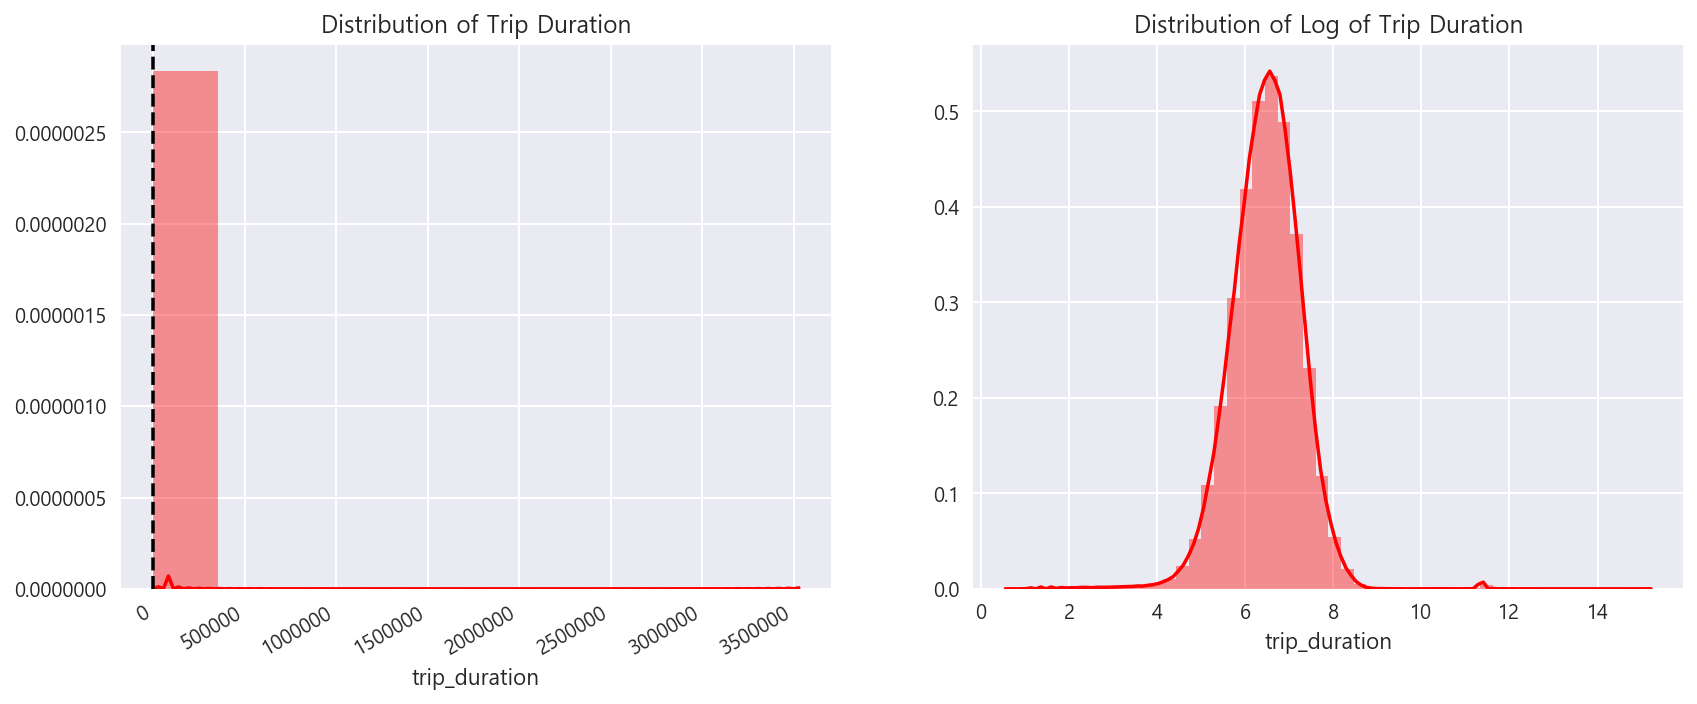

In [21]:
plt.figure(figsize=(14, 5))

plt.subplot(121)
sns.distplot(train["trip_duration"], color="r",bins=10)
plt.axvline(train["trip_duration"].median(), linestyle='dashed', color="k")
plt.xticks(rotation=30, ha='right')
plt.title("Distribution of Trip Duration")

plt.subplot(122)
sns.distplot(np.log1p(train["trip_duration"]), color="r")
plt.title("Distribution of Log of Trip Duration")

plt.show()

### 종속변수/독립변수 분리 후 pairplot
- 실수 변수
- 카테고리 변수

In [22]:
X_cols = [col for col in train.columns if col != "trip_duration"]
train_X0 = train[X_cols]
train_y = train[["trip_duration"]]

In [23]:
col_real = ["passenger_count", "distance", "bearing", "pickup_longitude", 
            "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]

col_cats = [col for col in train.columns if col not in col_real]
for col in ["pickup_datetime", "dropoff_datetime", "id"]:
    col_cats.remove(col)
col_cats_nontime = ["vendor_id", "store_and_fwd_flag", "working_day"]

### trip_duration ~ 실수 변수  pairplot
- trip_duration
- passenger_count
- distance
- bearing

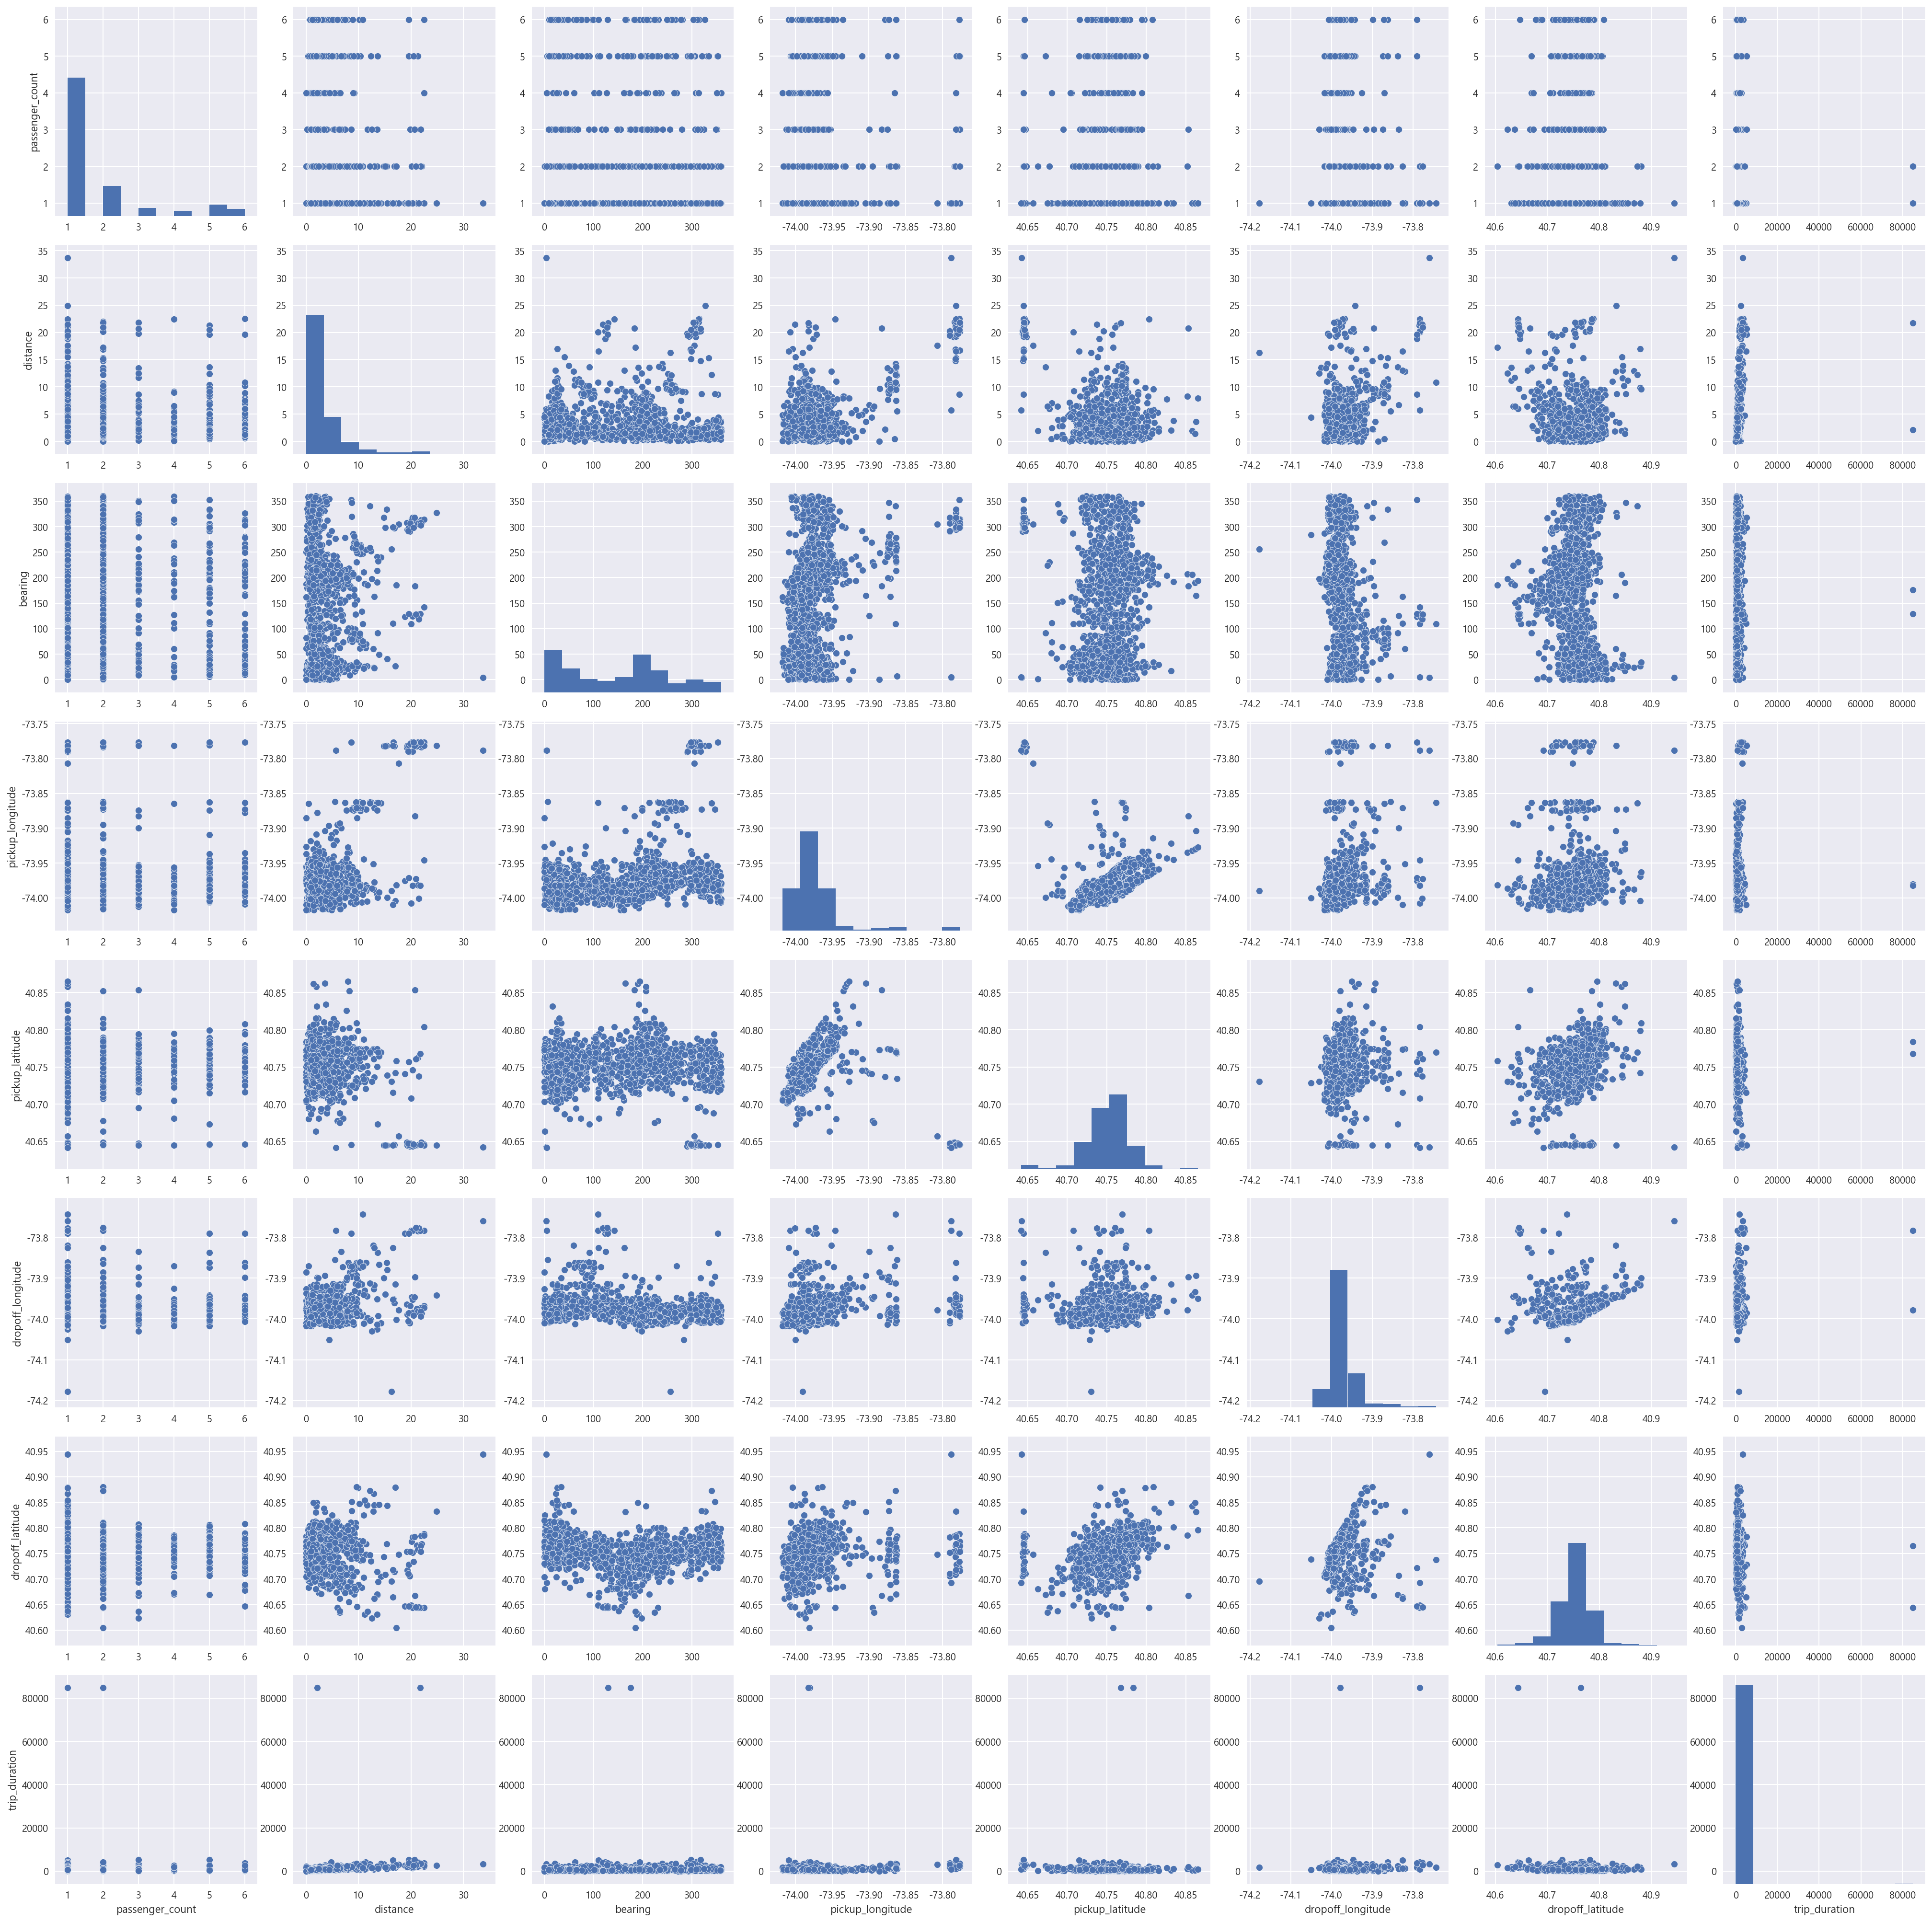

In [24]:
# passenger_count, distance, avg_speed_h

sns.pairplot(pd.concat([train_X0[col_real], train_y], axis=1)[::1000], size=3.5)
plt.show()

### 카테고리 변수 boxplot

In [25]:
def display_boxplots(start_features, row, col):
    with plt.style.context(('seaborn-darkgrid')):
        f, axes = plt.subplots(row, col, figsize=(12, 6), sharey=True)
        nums = row * col
        start_idx = col_cats_nontime.index(start_features)

        for num, ax in zip(range(nums), axes.flat):
            try: 
                sns.boxplot(x=train_X0[col_cats_nontime[start_idx + num]], 
                            y=np.log1p(train_y["trip_duration"]), palette="husl", ax=ax)
                ax.set_ylabel("log of trip duration")
            except:
                pass

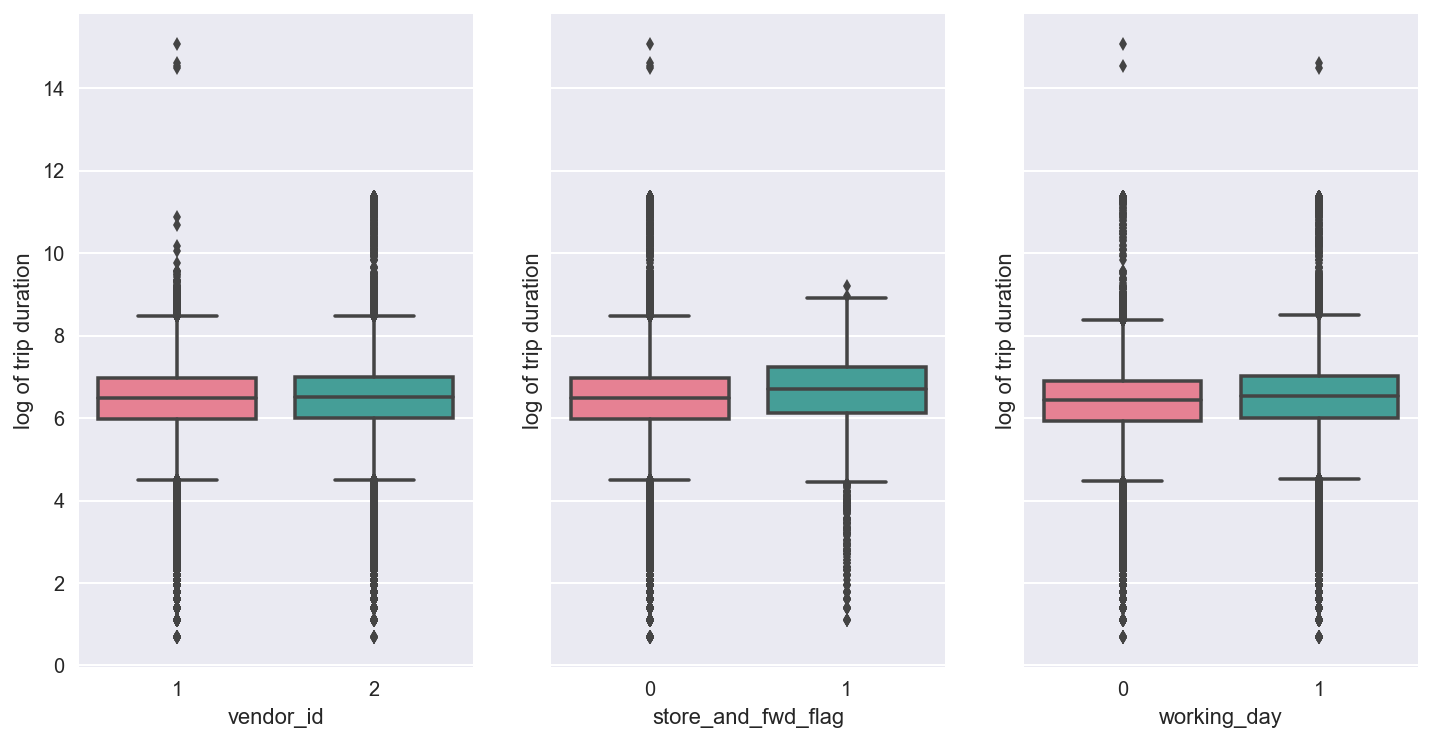

In [26]:
display_boxplots("vendor_id", 1, 3)

### 위치 변수의 지도상 분포

In [27]:
import folium
map_nyc = folium.Map(location=[40.767937, -73.982155], tiles='OpenStreetMap', zoom_start=11)
#tile: 'OpenStreetMap','Stamen Terrain','Mapbox Bright','Mapbox Control room'

for idx, row in train[:200].iterrows():
    if pd.notnull(row["pickup_latitude"]):
        folium.CircleMarker([row['pickup_latitude'], row['pickup_longitude']], 
                            radius=4, color="red", fill=True, fill_color="red").add_to(map_nyc)
        
map_nyc

### 시간 변수 plot

### trip_duration ~ pickup_month 

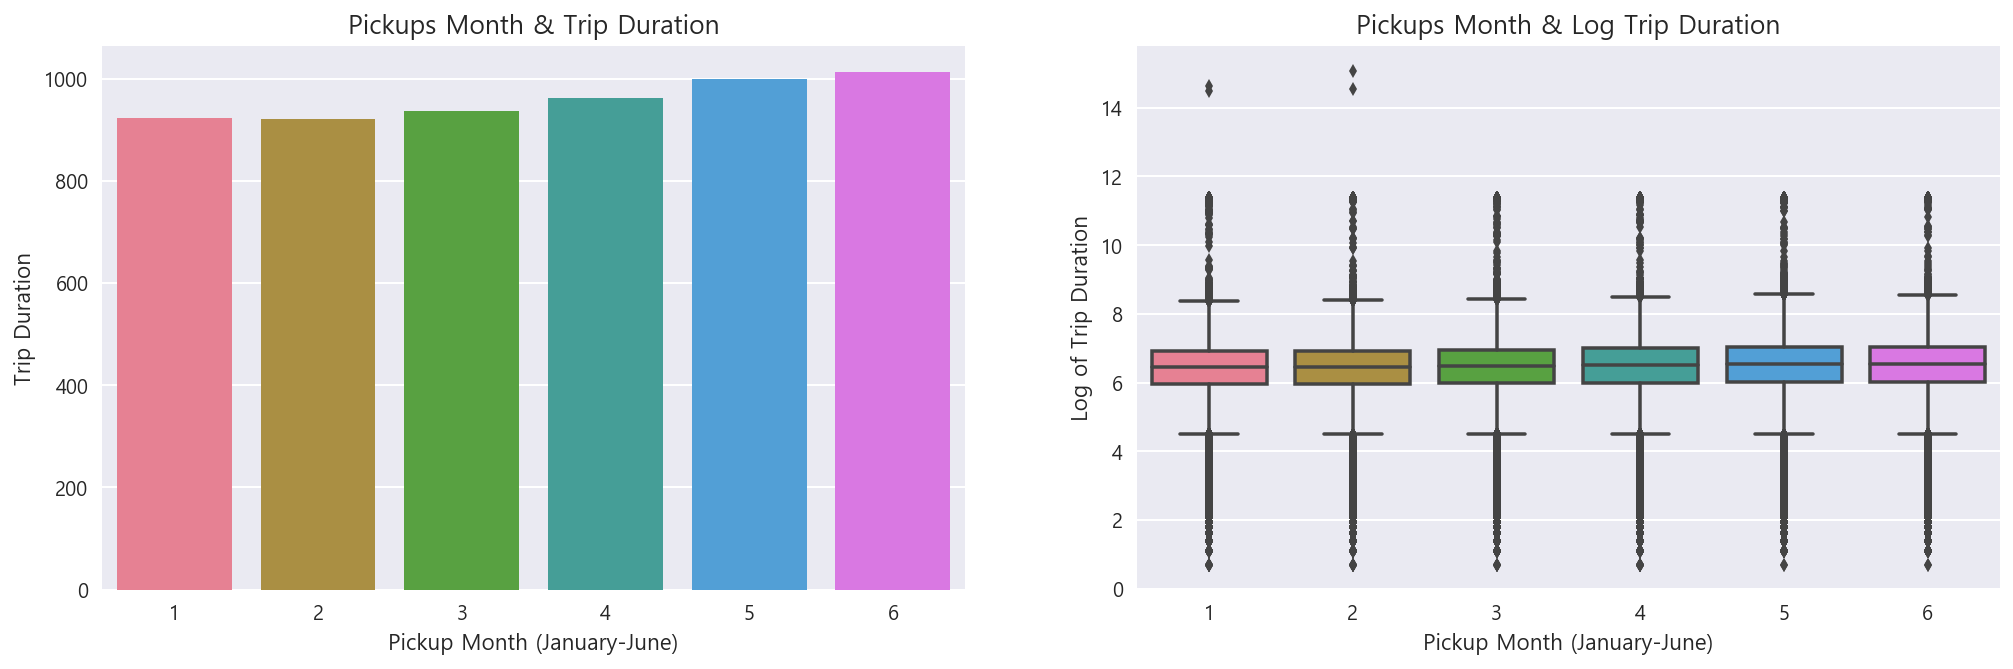

In [28]:
data = train.loc[:, ["pickup_month", "trip_duration"]].groupby("pickup_month").mean()

plt.figure(figsize=(17, 5))

plt.subplot(121)
sns.barplot(x=data.index, y=data.trip_duration, data=data, palette="husl")
plt.title("Pickups Month & Trip Duration", fontsize=13)
plt.xlabel("Pickup Month (January-June)")
plt.ylabel("Trip Duration")

plt.subplot(122)
sns.boxplot(x=train["pickup_month"], y=np.log1p(train["trip_duration"]), palette="husl")
plt.title("Pickups Month & Log Trip Duration", fontsize=13)
plt.xlabel("Pickup Month (January-June)")
plt.ylabel("Log of Trip Duration")

plt.show()

### trip_duration ~ pickup_weekday

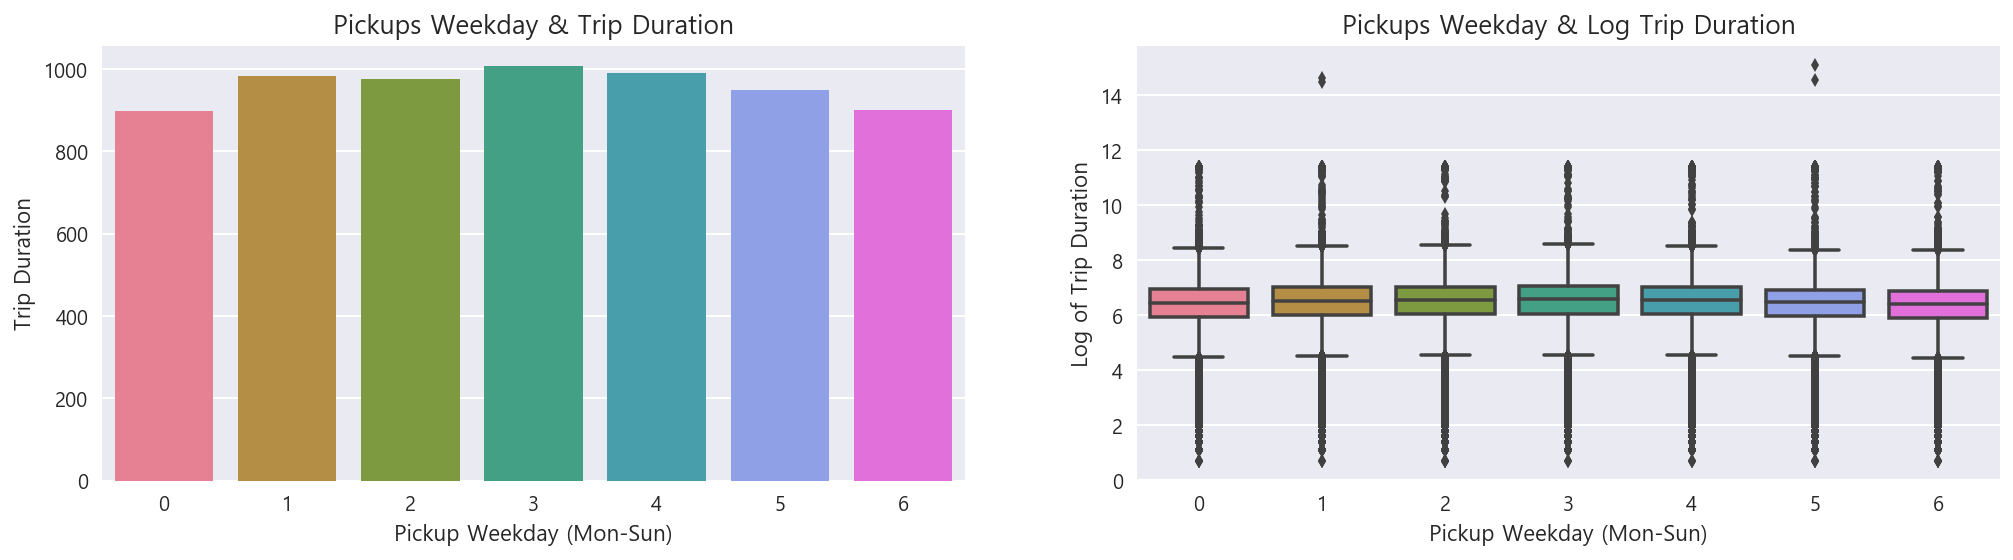

In [29]:
data = train.loc[:, ["pickup_weekday", "trip_duration"]].groupby("pickup_weekday").mean()

plt.figure(figsize=(17, 4))

plt.subplot(121)
sns.barplot(x=data.index, y=data.trip_duration, data=data, palette="husl")
plt.title("Pickups Weekday & Trip Duration", fontsize=13)
plt.xlabel("Pickup Weekday (Mon-Sun)")
plt.ylabel("Trip Duration")

plt.subplot(122)
sns.boxplot(x=train["pickup_weekday"], y=np.log1p(train["trip_duration"]), palette="husl")
plt.title("Pickups Weekday & Log Trip Duration", fontsize=13)
plt.xlabel("Pickup Weekday (Mon-Sun)")
plt.ylabel("Log of Trip Duration")

plt.show()

### trip_duration ~ pickup_hour

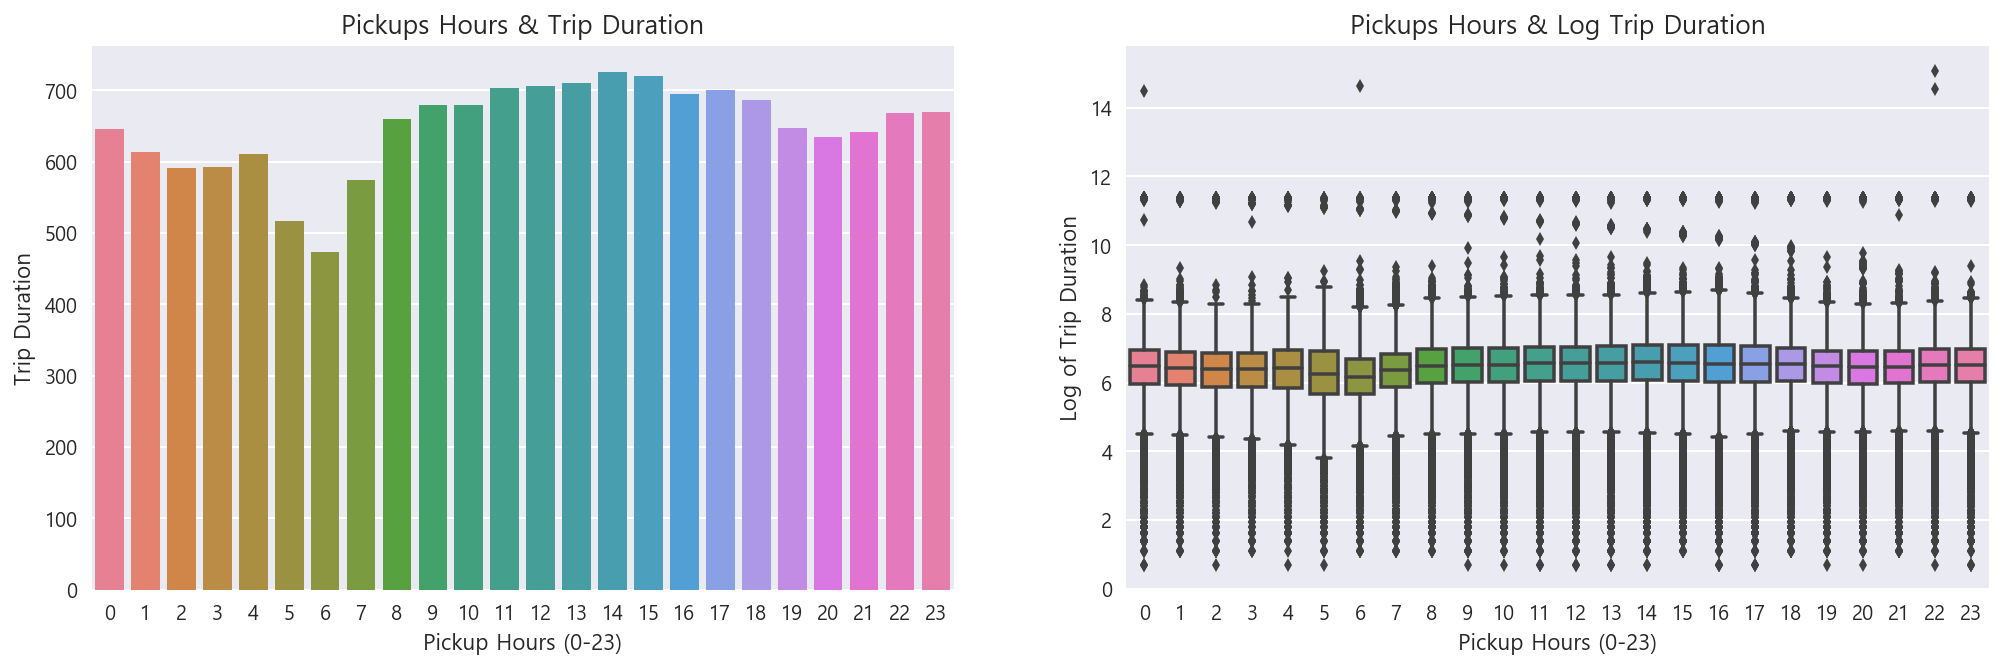

In [30]:
data = train.loc[:, ["pickup_hour", "trip_duration"]].groupby("pickup_hour").median()

plt.figure(figsize=(17, 5))

plt.subplot(121)
sns.barplot(x=data.index, y=data.trip_duration, data=data, palette="husl")
plt.title("Pickups Hours & Trip Duration", fontsize=13)
plt.xlabel("Pickup Hours (0-23)")
plt.ylabel("Trip Duration")


plt.subplot(122)
sns.boxplot(x=train["pickup_hour"], y=np.log1p(train["trip_duration"]), palette="husl")
plt.title("Pickups Hours & Log Trip Duration", fontsize=13)
plt.xlabel("Pickup Hours (0-23)")
plt.ylabel("Log of Trip Duration")

plt.show()

### working_day를 반영한 pickup_month

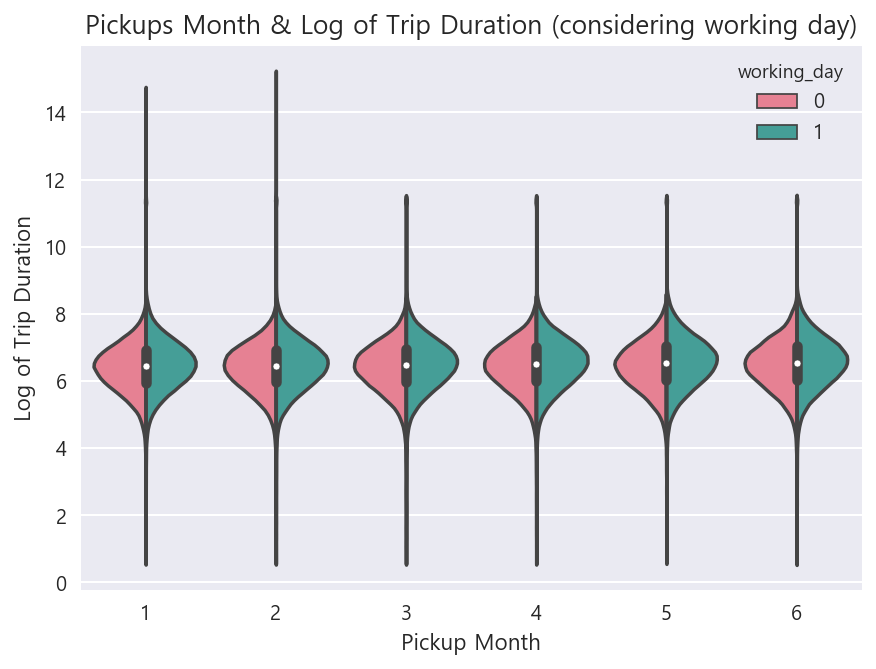

In [31]:
wd = train.loc[:, ["pickup_month", "pickup_hour", "trip_duration", "working_day"]]

plt.figure(figsize=(7, 5))
sns.violinplot(x=wd["pickup_month"], 
               y=wd["trip_duration"].apply(np.log1p),
               hue="working_day",
               data=wd, palette="husl", split=True)
plt.title("Pickups Month & Log of Trip Duration (considering working day)", fontsize=13)
plt.xlabel("Pickup Month")
plt.ylabel("Log of Trip Duration")
# plt.xticks(range(0, 6), month)
plt.show()

### working_day를 반영한 pickup_hour

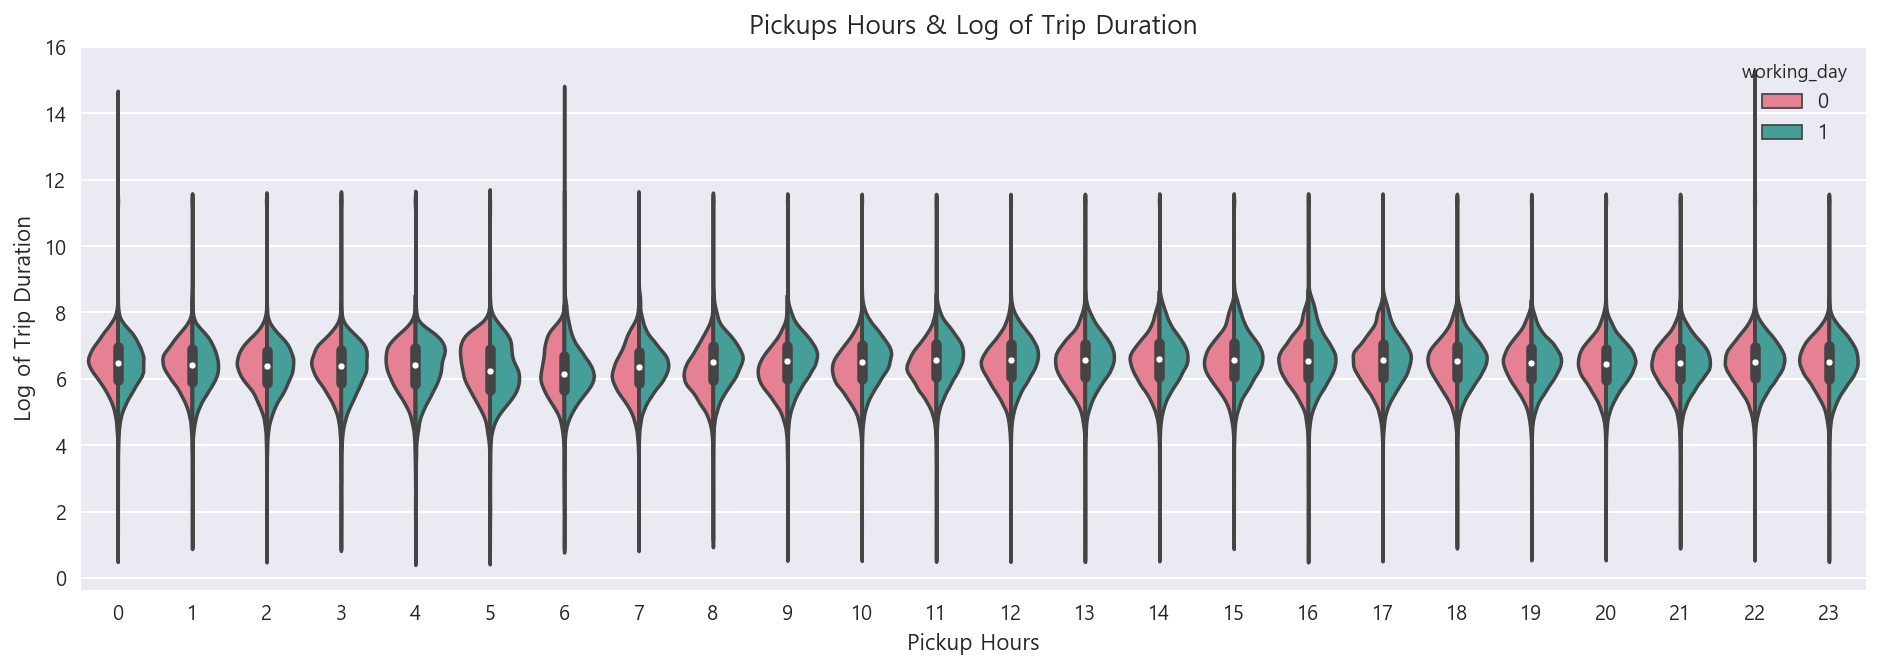

In [32]:
wd = train.loc[:, ["pickup_month", "pickup_hour", "trip_duration", "working_day"]]

plt.figure(figsize=(16, 5))
sns.violinplot(x=wd["pickup_hour"], 
               y=wd["trip_duration"].apply(np.log1p),
               hue="working_day",
               data=wd, palette="husl", split=True)
plt.title("Pickups Hours & Log of Trip Duration", fontsize=13)
plt.xlabel("Pickup Hours")
plt.ylabel("Log of Trip Duration")
# plt.xticks(range(0, 6), month)
plt.show()

### 2-2. 변수간 상관관계 heatmap

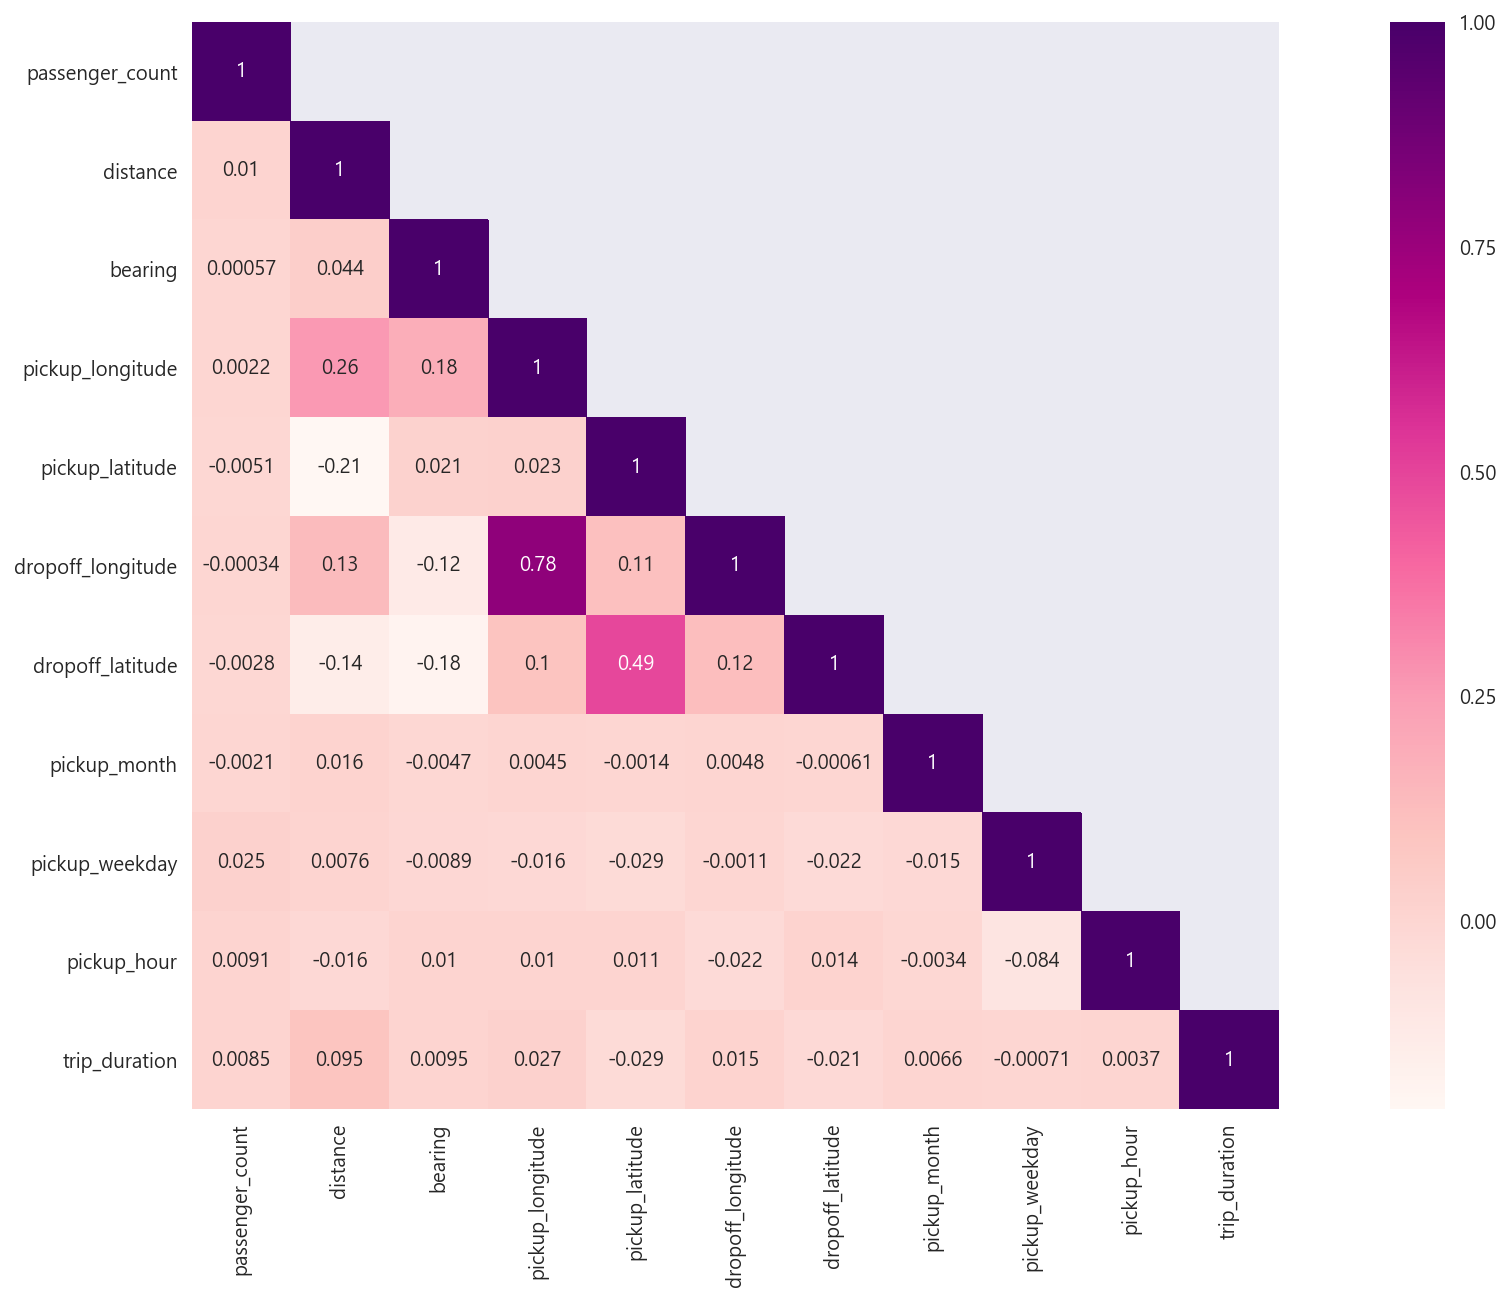

In [33]:
col_reals = col_real + ["pickup_month", "pickup_weekday", "pickup_hour", "trip_duration"]

corr_matt = train[col_reals].corr()
mask = np.array(corr_matt)
mask[np.tril_indices_from(mask)] = False

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(corr_matt, mask=mask, annot=True, square=True, cmap="RdPu")
plt.show()

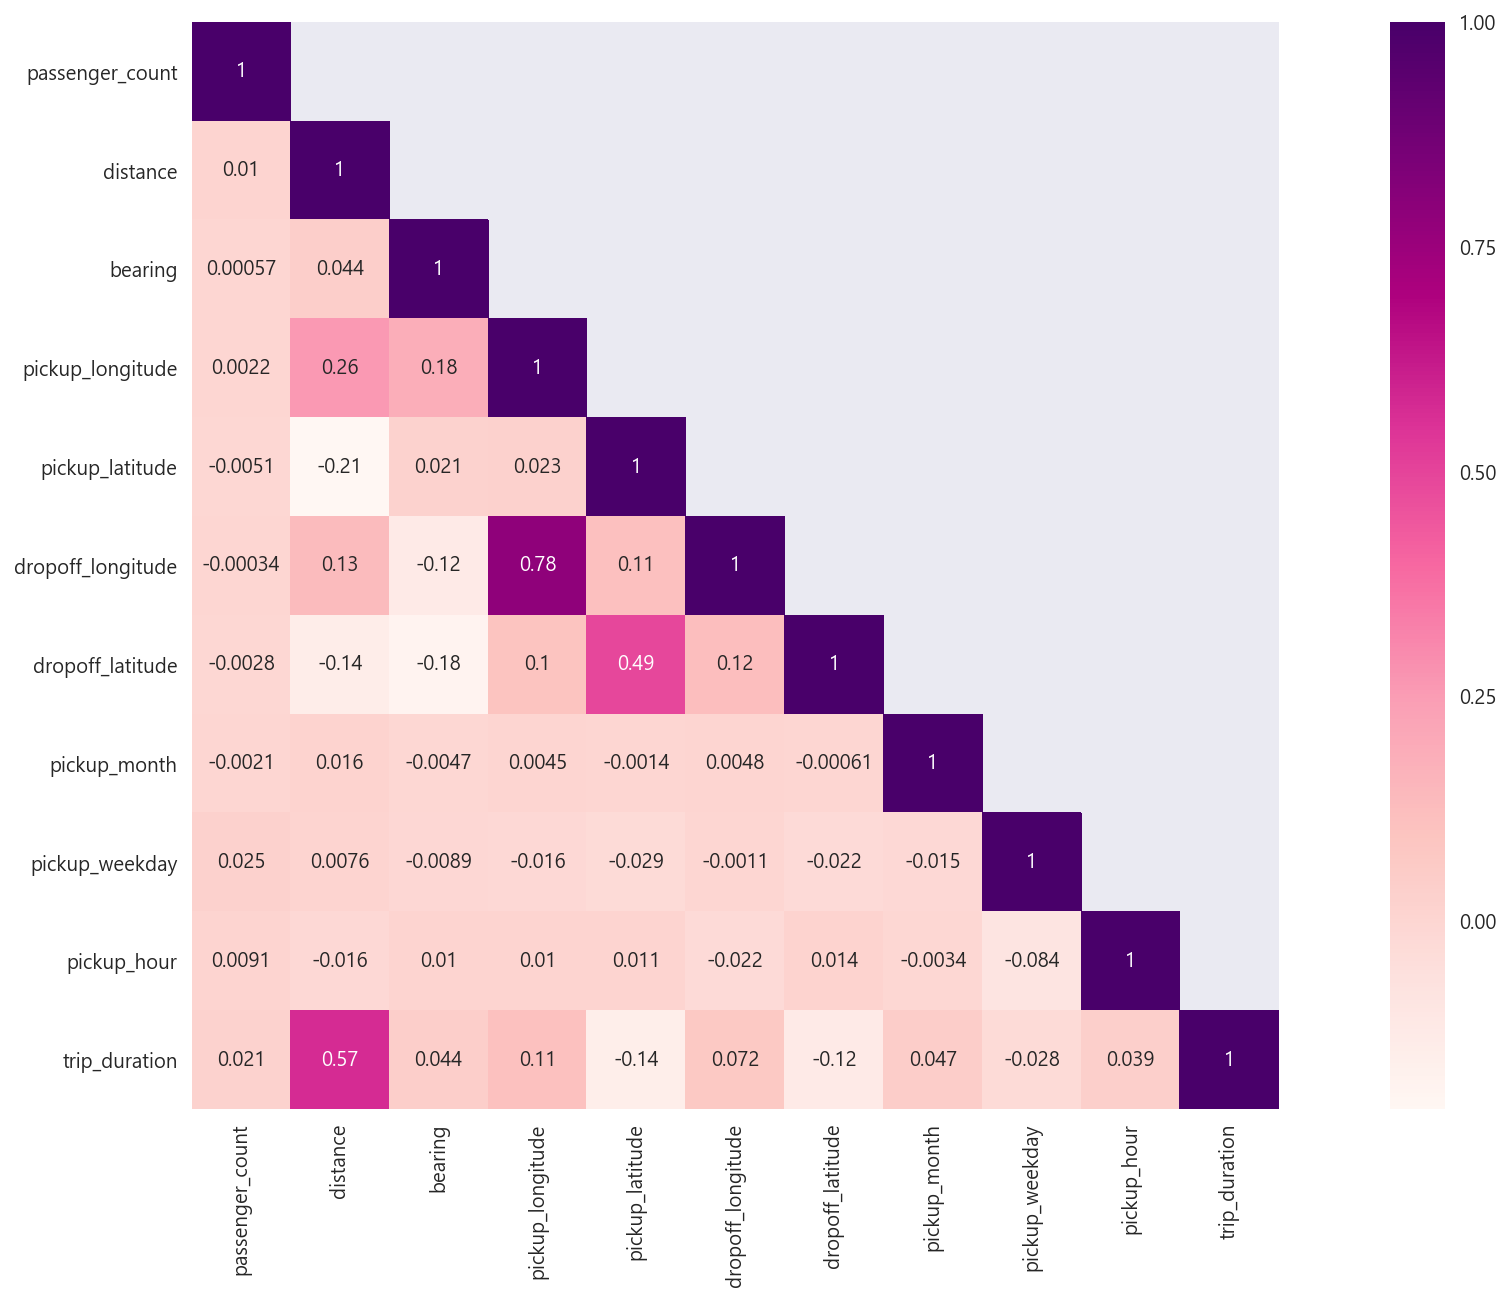

In [34]:
train_log = train[col_reals].copy()
train_log["trip_duration"] = np.log1p(train_log["trip_duration"])

corr_matt_log = train_log.corr()
mask = np.array(corr_matt)
mask[np.tril_indices_from(mask)] = False

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(corr_matt_log, mask=mask, annot=True, square=True, cmap="RdPu")
plt.show()

### 2-2. 변수 중요도 파악 (F-검정)

### 전체 변수 F-검정

In [35]:
model = sm.OLS.from_formula("trip_duration ~ passenger_count + distance + bearing + pickup_month +" 
                            "pickup_weekday + pickup_hour + pickup_latitude + pickup_longitude +"
                            "dropoff_latitude + dropoff_longitude + C(vendor_id) + C(store_and_fwd_flag)"
                            "+ C(working_day)", train)
result = model.fit()

In [36]:
print("R-squared of a model:", result.rsquared)
print("Adjusted R-squared of a model:", result.rsquared_adj)

R-squared of a model: 0.00962066154291
Adjusted R-squared of a model: 0.00961183481413


#### [결과]
- $R^2$와 $Adj. R^2$ 모두 매우 낮음
- 모든 변수들의 p-value가 0에 가까움

In [37]:
sm.stats.anova_lm(result, typ=2)

,sum_sq,df,F,PR(>F)
C(vendor_id),1.322501e+10,1.0,486.803677,7.362210e-108
C(store_and_fwd_flag),1.857535e+07,1.0,0.683746,4.082998e-01
C(working_day),1.623896e+09,1.0,59.774498,1.064401e-14
passenger_count,1.626971e+08,1.0,5.988770,1.439736e-02
distance,2.955514e+11,1.0,10879.047719,0.000000e+00
bearing,1.599128e+09,1.0,58.862798,1.691624e-14
pickup_month,1.129914e+09,1.0,41.591364,1.125240e-10
pickup_weekday,6.883444e+08,1.0,25.337491,4.813203e-07
pickup_hour,9.624404e+08,1.0,35.426777,2.648812e-09
pickup_latitude,2.846822e+09,1.0,104.789572,1.360810e-24


### 카테고리 변수 영향도 파악(t-검정, F-검정)

### t-검정

In [38]:
def ttest_ind_cats(var):
    tmp_list = train[var].unique()
    print(sp.stats.ttest_ind(train["trip_duration"][train[var] == tmp_list[0]], 
                             train["trip_duration"][train[var] == tmp_list[1]]))

In [39]:
bin_cats = ["vendor_id", "store_and_fwd_flag", "working_day"]

for _, elem in enumerate(bin_cats):
    print("[ {} ]".format(elem))
    ttest_ind_cats(elem)
    print("-" * 80)    

[ vendor_id ]
Ttest_indResult(statistic=24.527274857356531, pvalue=8.046167819039434e-133)
--------------------------------------------------------------------------------
[ store_and_fwd_flag ]
Ttest_indResult(statistic=-2.0825876188794363, pvalue=0.037289002528894187)
--------------------------------------------------------------------------------
[ working_day ]
Ttest_indResult(statistic=4.8414640555035238, pvalue=1.288991482784057e-06)
--------------------------------------------------------------------------------


### One-Way ANOVA
- vendor_id
- store_and_fwd_flag
- working_day

In [40]:
model_wd = sm.OLS.from_formula("np.log1p(trip_duration) ~ C(vendor_id) + 0", data=train)
sm.stats.anova_lm(model_wd.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(vendor_id),2.0,6.100349e+07,3.050175e+07,4.818697e+07,0.0
Residual,1458642.0,9.233020e+05,6.329874e-01,NaN,NaN


In [42]:
sp.stats.f_oneway(train[train["working_day"]==0]["trip_duration"], 
                  train[train["working_day"]==1]["trip_duration"])

F_onewayResult(statistic=23.439774200732664, pvalue=1.288991484260018e-06)

In [44]:
sp.stats.f_oneway(train[train["store_and_fwd_flag"]==0]["trip_duration"], 
                  train[train["store_and_fwd_flag"]==1]["trip_duration"])

F_onewayResult(statistic=4.337171190309931, pvalue=0.037289002569931756)

In [45]:
sp.stats.f_oneway(train[train["vendor_id"]==1]["trip_duration"], 
                  train[train["vendor_id"]==2]["trip_duration"])

F_onewayResult(statistic=601.58721192831376, pvalue=8.0461678290238255e-133)

-------------------------------------------------------------

In [119]:
# train.to_csv("train_trans.csv", index = False)
# test.to_csv("test_trans.csv", index = False)

-------------------------------------------------------------

## 3. OLS 회귀분석

3-1. 모든변수(C(vendor_id) + C(store_and_fwd_flag) + C(working_day) + passenger_count + distance + bearing + pickup_month + pickup_weekday + pickup_hour + pickup_latitude + pickup_longitude + dropoff_latitude + dropoff_longitude)를 넣은 OLS 결과

In [52]:
model1 = sm.OLS.from_formula("np.log1p(trip_duration) ~  C(vendor_id) + C(store_and_fwd_flag) + C(working_day) + passenger_count + distance + bearing + pickup_month + pickup_weekday + pickup_hour + pickup_latitude + pickup_longitude + dropoff_latitude + dropoff_longitude - 1", train)
result1 = model1.fit()
print(result1.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.344
Model:                                 OLS   Adj. R-squared:                  0.344
Method:                      Least Squares   F-statistic:                 5.895e+04
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             11:15:06   Log-Likelihood:            -1.4285e+06
No. Observations:                  1458644   AIC:                         2.857e+06
Df Residuals:                      1458630   BIC:                         2.857e+06
Df Model:                               13                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

3-2. 모든변수 - C(store_and_fwd_flag)

In [53]:
model2 = sm.OLS.from_formula("np.log1p(trip_duration) ~  C(vendor_id) + C(working_day) + passenger_count + distance + bearing + pickup_month + pickup_weekday + pickup_hour + pickup_latitude + pickup_longitude + dropoff_latitude + dropoff_longitude - 1", train)
result2 = model2.fit()
print(result2.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.344
Model:                                 OLS   Adj. R-squared:                  0.344
Method:                      Least Squares   F-statistic:                 6.386e+04
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             11:15:26   Log-Likelihood:            -1.4285e+06
No. Observations:                  1458644   AIC:                         2.857e+06
Df Residuals:                      1458631   BIC:                         2.857e+06
Df Model:                               12                                         
Covariance Type:                 nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

3-3. 모든변수 - C(store_and_fwd_flag) & 실수값 스케일링

In [55]:
model3 = sm.OLS.from_formula("np.log1p(trip_duration) ~  C(vendor_id) + C(working_day) + scale(passenger_count) + scale(distance) + scale(bearing) + scale(pickup_month) + scale(pickup_weekday) + scale(pickup_hour) + scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) - 1", train)
result3 = model3.fit()
print(result3.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.344
Model:                                 OLS   Adj. R-squared:                  0.344
Method:                      Least Squares   F-statistic:                 6.386e+04
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             11:25:03   Log-Likelihood:            -1.4285e+06
No. Observations:                  1458644   AIC:                         2.857e+06
Df Residuals:                      1458631   BIC:                         2.857e+06
Df Model:                               12                                         
Covariance Type:                 nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

3-4. 모든변수 - C(store_and_fwd_flag) & 실수값 스케일링 & pickup_hour 2차 다항회귀

In [56]:
model4 = sm.OLS.from_formula("np.log1p(trip_duration) ~  C(vendor_id) + C(working_day) + scale(passenger_count) + scale(distance) + scale(bearing) + scale(pickup_month) + scale(pickup_weekday) + scale(pickup_hour) + scale(I(pickup_hour**2)) + scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) - 1", train)
result4 = model4.fit()
print(result4.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.353
Model:                                 OLS   Adj. R-squared:                  0.353
Method:                      Least Squares   F-statistic:                 6.123e+04
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             11:34:43   Log-Likelihood:            -1.4189e+06
No. Observations:                  1458644   AIC:                         2.838e+06
Df Residuals:                      1458630   BIC:                         2.838e+06
Df Model:                               13                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

3-5. 모든변수 - C(store_and_fwd_flag) & 실수값 스케일링 & pickup_hour 2, 3차 다항회귀

In [57]:
model5 = sm.OLS.from_formula("np.log1p(trip_duration) ~  C(vendor_id) + C(working_day) + scale(passenger_count) + scale(distance) + scale(bearing) + scale(pickup_month) + scale(pickup_weekday) + scale(pickup_hour) + scale(I(pickup_hour**2))+ scale(I(pickup_hour**3)) + scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) - 1", train)
result5 = model5.fit()
print(result5.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.355
Model:                                 OLS   Adj. R-squared:                  0.355
Method:                      Least Squares   F-statistic:                 5.747e+04
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             11:45:50   Log-Likelihood:            -1.4161e+06
No. Observations:                  1458644   AIC:                         2.832e+06
Df Residuals:                      1458629   BIC:                         2.832e+06
Df Model:                               14                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

3-6. 모든변수 - C(store_and_fwd_flag) & 실수값 스케일링 & pickup_hour 2, 3차 다항회귀 & distance 2차 다항회귀

In [58]:
model6 = sm.OLS.from_formula("np.log1p(trip_duration) ~  C(vendor_id) + C(working_day) + scale(passenger_count) + scale(distance) + scale(I(distance**2)) + scale(bearing) + scale(pickup_month) + scale(pickup_weekday) + scale(pickup_hour) + scale(I(pickup_hour**2))+ scale(I(pickup_hour**3)) + scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) - 1", train)
result6 = model6.fit()
print(result6.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.410
Model:                                 OLS   Adj. R-squared:                  0.410
Method:                      Least Squares   F-statistic:                 6.760e+04
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             11:53:26   Log-Likelihood:            -1.3516e+06
No. Observations:                  1458644   AIC:                         2.703e+06
Df Residuals:                      1458628   BIC:                         2.703e+06
Df Model:                               15                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

3-7. 모든변수 - C(store_and_fwd_flag) & 실수값 스케일링 & pickup_hour 2, 3차 다항회귀 & distance 2, 3차 다항회귀

In [60]:
model7 = sm.OLS.from_formula("np.log1p(trip_duration) ~  C(vendor_id) + C(working_day) + scale(passenger_count) + scale(distance) + scale(I(distance**2)) + scale(I(distance**3)) + scale(bearing) + scale(pickup_month) + scale(pickup_weekday) + scale(pickup_hour) + scale(I(pickup_hour**2))+ scale(I(pickup_hour**3)) + scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) - 1", train)
result7 = model7.fit()
print(result7.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.424
Model:                                 OLS   Adj. R-squared:                  0.424
Method:                      Least Squares   F-statistic:                 6.700e+04
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             12:04:01   Log-Likelihood:            -1.3347e+06
No. Observations:                  1458644   AIC:                         2.669e+06
Df Residuals:                      1458627   BIC:                         2.670e+06
Df Model:                               16                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

3-8. 모든변수 - C(store_and_fwd_flag) & 실수값 스케일링 & pickup_hour 2, 3차 다항회귀 & distance 2, 3, 4차 다항회귀

In [61]:
model8 = sm.OLS.from_formula("np.log1p(trip_duration) ~  C(vendor_id) + C(working_day) + scale(passenger_count) + scale(distance) + scale(I(distance**2)) + scale(I(distance**3)) + scale(I(distance**4)) + scale(bearing) + scale(pickup_month) + scale(pickup_weekday) + scale(pickup_hour) + scale(I(pickup_hour**2))+ scale(I(pickup_hour**3)) + scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) - 1", train)
result8 = model8.fit()
print(result8.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.442
Model:                                 OLS   Adj. R-squared:                  0.442
Method:                      Least Squares   F-statistic:                 6.805e+04
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             12:10:30   Log-Likelihood:            -1.3106e+06
No. Observations:                  1458644   AIC:                         2.621e+06
Df Residuals:                      1458626   BIC:                         2.621e+06
Df Model:                               17                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

3-9. 모든변수 - C(store_and_fwd_flag) & 실수값 스케일링 & pickup_hour 2, 3차 다항회귀 & distance 2, 3, 4차 다항회귀 & speed 추가

In [77]:
model9 = sm.OLS.from_formula("np.log1p(trip_duration) ~  C(vendor_id) + C(working_day) + scale(passenger_count) + scale(distance) + scale(I(distance**2)) + scale(I(distance**3)) + scale(I(distance**4)) + scale(bearing) + scale(pickup_month) + scale(pickup_weekday) + scale(pickup_hour) + scale(I(pickup_hour**2))+ scale(I(pickup_hour**3)) + scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) + scale(avg_speed_km_h) - 1", train)
result9 = model9.fit()
print(result9.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.498
Model:                                 OLS   Adj. R-squared:                  0.498
Method:                      Least Squares   F-statistic:                 8.053e+04
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             12:46:30   Log-Likelihood:            -1.2332e+06
No. Observations:                  1458644   AIC:                         2.466e+06
Df Residuals:                      1458625   BIC:                         2.467e+06
Df Model:                               18                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

3-10. 모든변수 - C(store_and_fwd_flag) & 실수값 스케일링 & pickup_hour 2, 3차 다항회귀 & distance 2, 3, 4차 다항회귀 & speed 추가 & speed 2차 다항회귀

In [78]:
model10 = sm.OLS.from_formula("np.log1p(trip_duration) ~  C(vendor_id) + C(working_day) + scale(passenger_count) + scale(distance) + scale(I(distance**2)) + scale(I(distance**3)) + scale(I(distance**4)) + scale(bearing) + scale(pickup_month) + scale(pickup_weekday) + scale(pickup_hour) + scale(I(pickup_hour**2))+ scale(I(pickup_hour**3)) + scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) + scale(avg_speed_km_h) + scale(I(avg_speed_km_h**2)) - 1", train)
result10 = model10.fit()
print(result10.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.581
Model:                                 OLS   Adj. R-squared:                  0.581
Method:                      Least Squares   F-statistic:                 1.066e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             13:06:07   Log-Likelihood:            -1.1013e+06
No. Observations:                  1458644   AIC:                         2.203e+06
Df Residuals:                      1458624   BIC:                         2.203e+06
Df Model:                               19                                         
Covariance Type:                 nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

3-11. 모든변수 - C(store_and_fwd_flag) & 실수값 스케일링 & pickup_hour 2, 3차 다항회귀 & distance 2, 3, 4차 다항회귀 & speed 추가 & speed 3차 다항회귀

In [80]:
model11 = sm.OLS.from_formula("np.log1p(trip_duration) ~  C(vendor_id) + C(working_day) + scale(passenger_count) + scale(distance) + scale(I(distance**2)) + scale(I(distance**3)) + scale(I(distance**4)) + scale(bearing) + scale(pickup_month) + scale(pickup_weekday) + scale(pickup_hour) + scale(I(pickup_hour**2))+ scale(I(pickup_hour**3)) + scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) + scale(avg_speed_km_h) + scale(I(avg_speed_km_h**2)) + scale(I(avg_speed_km_h**3)) - 1", train)
result11 = model11.fit()
print(result11.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.596
Model:                                 OLS   Adj. R-squared:                  0.596
Method:                      Least Squares   F-statistic:                 1.078e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             13:16:40   Log-Likelihood:            -1.0747e+06
No. Observations:                  1458644   AIC:                         2.149e+06
Df Residuals:                      1458623   BIC:                         2.150e+06
Df Model:                               20                                         
Covariance Type:                 nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

3-12. 모든변수 - C(store_and_fwd_flag) & 실수값 스케일링 & pickup_hour 2, 3차 다항회귀 & distance 2, 3, 4, 5차 다항회귀 & speed 추가 & speed 3차 다항회귀

In [81]:
model12 = sm.OLS.from_formula("np.log1p(trip_duration) ~  C(vendor_id) + C(working_day) + scale(passenger_count) + scale(distance) + scale(I(distance**2)) + scale(I(distance**3)) + scale(I(distance**4)) + scale(I(distance**5)) + scale(bearing) + scale(pickup_month) + scale(pickup_weekday) + scale(pickup_hour) + scale(I(pickup_hour**2))+ scale(I(pickup_hour**3)) + scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) + scale(avg_speed_km_h) + scale(I(avg_speed_km_h**2)) + scale(I(avg_speed_km_h**3)) - 1", train)
result12 = model12.fit()
print(result12.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.637
Model:                                 OLS   Adj. R-squared:                  0.637
Method:                      Least Squares   F-statistic:                 1.218e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             13:58:21   Log-Likelihood:            -9.9761e+05
No. Observations:                  1458644   AIC:                         1.995e+06
Df Residuals:                      1458622   BIC:                         1.996e+06
Df Model:                               21                                         
Covariance Type:                 nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

3-13. 모든변수 - C(store_and_fwd_flag) & 실수값 스케일링 & pickup_hour 2, 3차 다항회귀 & distance 2, 3, 4차 다항회귀 & speed 추가 & speed 3차 다항회귀 & C(vendor_id) 제거 

In [82]:
model13 = sm.OLS.from_formula("np.log1p(trip_duration) ~  C(working_day) + scale(passenger_count) + scale(distance) + scale(I(distance**2)) + scale(I(distance**3)) + scale(I(distance**4)) + scale(bearing) + scale(pickup_month) + scale(pickup_weekday) + scale(pickup_hour) + scale(I(pickup_hour**2))+ scale(I(pickup_hour**3)) + scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) + scale(avg_speed_km_h) + scale(I(avg_speed_km_h**2)) + scale(I(avg_speed_km_h**3)) - 1", train)
result13 = model13.fit()
print(result13.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.596
Model:                                 OLS   Adj. R-squared:                  0.596
Method:                      Least Squares   F-statistic:                 1.134e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             14:06:45   Log-Likelihood:            -1.0749e+06
No. Observations:                  1458644   AIC:                         2.150e+06
Df Residuals:                      1458624   BIC:                         2.150e+06
Df Model:                               19                                         
Covariance Type:                 nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

3-14. 모든변수 - C(store_and_fwd_flag) & 실수값 스케일링 & pickup_hour 2, 3차 다항회귀 & distance 2, 3, 4차 다항회귀 & speed 추가 & speed 3차 다항회귀 & C(vendor_id) 제거 & C(working_day) 제거

In [83]:
model14 = sm.OLS.from_formula("np.log1p(trip_duration) ~   scale(passenger_count) + scale(distance) + scale(I(distance**2)) + scale(I(distance**3)) + scale(I(distance**4)) + scale(bearing) + scale(pickup_month) + scale(pickup_weekday) + scale(pickup_hour) + scale(I(pickup_hour**2))+ scale(I(pickup_hour**3)) + scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) + scale(avg_speed_km_h) + scale(I(avg_speed_km_h**2)) + scale(I(avg_speed_km_h**3)) ", train)
result14 = model14.fit()
print(result14.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.596
Model:                                 OLS   Adj. R-squared:                  0.596
Method:                      Least Squares   F-statistic:                 1.196e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             14:37:55   Log-Likelihood:            -1.0754e+06
No. Observations:                  1458644   AIC:                         2.151e+06
Df Residuals:                      1458625   BIC:                         2.151e+06
Df Model:                               18                                         
Covariance Type:                 nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

3-15. 모든변수 - C(store_and_fwd_flag) & 실수값 스케일링 & pickup_hour 2, 3차 다항회귀 & distance 2, 3, 4차 다항회귀 & speed 추가 & speed 3차 다항회귀 & C(vendor_id) 제거 & C(working_day) 제거& dropoff_longitude 제거

In [84]:
model15 = sm.OLS.from_formula("np.log1p(trip_duration) ~  scale(passenger_count) + scale(distance) + scale(I(distance**2)) + scale(I(distance**3)) + scale(I(distance**4)) + scale(bearing) + scale(pickup_month) + scale(pickup_weekday) + scale(pickup_hour) + scale(I(pickup_hour**2))+ scale(I(pickup_hour**3)) + scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(avg_speed_km_h) + scale(I(avg_speed_km_h**2)) + scale(I(avg_speed_km_h**3)) ", train)
result15 = model15.fit()
print(result15.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.596
Model:                                 OLS   Adj. R-squared:                  0.596
Method:                      Least Squares   F-statistic:                 1.266e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             14:46:44   Log-Likelihood:            -1.0754e+06
No. Observations:                  1458644   AIC:                         2.151e+06
Df Residuals:                      1458626   BIC:                         2.151e+06
Df Model:                               17                                         
Covariance Type:                 nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

3-16. 모든변수 - C(store_and_fwd_flag) & 실수값 스케일링 & pickup_hour 2차 다항회귀 & distance 2, 3, 4차 다항회귀 & speed 추가 & speed 3차 다항회귀 & C(vendor_id) 제거 & pickup_hour 3차 제거

In [85]:
model16 = sm.OLS.from_formula("np.log1p(trip_duration) ~  C(working_day) + scale(passenger_count) + scale(distance) + scale(I(distance**2)) + scale(I(distance**3)) + scale(I(distance**4)) + scale(bearing) + scale(pickup_month) + scale(pickup_weekday) + scale(pickup_hour) + scale(I(pickup_hour**2)) + scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) + scale(avg_speed_km_h) + scale(I(avg_speed_km_h**2)) + scale(I(avg_speed_km_h**3)) - 1", train)
result16 = model16.fit()
print(result16.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.596
Model:                                 OLS   Adj. R-squared:                  0.596
Method:                      Least Squares   F-statistic:                 1.197e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             14:53:45   Log-Likelihood:            -1.0751e+06
No. Observations:                  1458644   AIC:                         2.150e+06
Df Residuals:                      1458625   BIC:                         2.150e+06
Df Model:                               18                                         
Covariance Type:                 nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

3-17. 모든변수 - C(store_and_fwd_flag) & 실수값 스케일링 & pickup_hour 2차 다항회귀 & distance 2, 3, 4차 다항회귀 & speed 추가 & speed 3차 다항회귀 & C(vendor_id) 제거 & pickup_hour 3차 제거 & distance 4차 제거

In [86]:
model17 = sm.OLS.from_formula("np.log1p(trip_duration) ~  C(working_day) + scale(passenger_count) + scale(distance) + scale(I(distance**2)) + scale(I(distance**3)) + scale(bearing) + scale(pickup_month) + scale(pickup_weekday) + scale(pickup_hour) + scale(I(pickup_hour**2)) + scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) + scale(avg_speed_km_h) + scale(I(avg_speed_km_h**2)) + scale(I(avg_speed_km_h**3)) - 1", train)
result17 = model17.fit()
print(result17.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.584
Model:                                 OLS   Adj. R-squared:                  0.584
Method:                      Least Squares   F-statistic:                 1.205e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             15:02:55   Log-Likelihood:            -1.0965e+06
No. Observations:                  1458644   AIC:                         2.193e+06
Df Residuals:                      1458626   BIC:                         2.193e+06
Df Model:                               17                                         
Covariance Type:                 nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [132]:
result17_2 = model17.fit_regularized(alpha=0.01, L1_wt=1)
print(result17_2.params)
print(result17_2.summary()) 

C(working_day)[0]                6.393121
C(working_day)[1]                6.468484
scale(passenger_count)           0.000000
scale(distance)                  0.728328
scale(I(distance ** 2))         -0.139477
scale(I(distance ** 3))          0.000000
scale(bearing)                   0.000000
scale(pickup_month)              0.007108
scale(pickup_weekday)            0.009246
scale(pickup_hour)               0.000394
scale(I(pickup_hour ** 2))       0.000000
scale(pickup_latitude)           0.027838
scale(pickup_longitude)         -0.038670
scale(dropoff_latitude)         -0.006396
scale(dropoff_longitude)         0.000000
scale(avg_speed_km_h)           -0.569946
scale(I(avg_speed_km_h ** 2))    0.364457
scale(I(avg_speed_km_h ** 3))    0.000000
dtype: float64
None


In [138]:
result17_3 = model17.fit_regularized(alpha=0.03, L1_wt=1)
print(result17_3.params)
print(result17_3.summary()) 

C(working_day)[0]                6.320726
C(working_day)[1]                6.441419
scale(passenger_count)           0.000000
scale(distance)                  0.624106
scale(I(distance ** 2))         -0.085012
scale(I(distance ** 3))          0.000000
scale(bearing)                   0.000000
scale(pickup_month)              0.000000
scale(pickup_weekday)            0.000000
scale(pickup_hour)               0.000000
scale(I(pickup_hour ** 2))       0.000000
scale(pickup_latitude)           0.000000
scale(pickup_longitude)         -0.006959
scale(dropoff_latitude)          0.000000
scale(dropoff_longitude)         0.000000
scale(avg_speed_km_h)           -0.406304
scale(I(avg_speed_km_h ** 2))    0.173265
scale(I(avg_speed_km_h ** 3))    0.039140
dtype: float64
None


In [139]:
result17_4 = model17.fit_regularized(alpha=0.01, L1_wt=0)
print(result17_4.params)
print(result17_4.summary()) 

[ 6.07583592  6.44791666  0.01018103  0.76229876 -0.33462206  0.14886248
 -0.02105777  0.01680768  0.12429404  0.04154243 -0.0350197   0.04506813
 -0.05905211 -0.02499684  0.01561224 -0.59172793  0.56665207 -0.16473406]
None


3-21. 모든변수 - C(store_and_fwd_flag) & 실수값 스케일링 & pickup_hour 2차 다항회귀 & distance 2, 3, 4차 다항회귀 & speed 추가 & speed 3차 다항회귀 & C(vendor_id) 제거 & pickup_hour 3차 제거 & distance 4차 제거 & pickup_longitude 2차 다항회귀

In [147]:
model21 = sm.OLS.from_formula("np.log1p(trip_duration) ~  C(working_day) + scale(passenger_count) + scale(distance) + scale(I(distance**2)) + scale(I(distance**3)) + scale(bearing) + scale(pickup_month) + scale(pickup_weekday) + scale(pickup_hour) + scale(I(pickup_hour**2)) + scale(pickup_latitude) + scale(pickup_longitude) + scale(I(pickup_longitude**2)) + scale(dropoff_latitude) + scale(dropoff_longitude) + scale(avg_speed_km_h) + scale(I(avg_speed_km_h**2)) + scale(I(avg_speed_km_h**3)) - 1", train)
result21 = model21.fit()
print(result21.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.591
Model:                                 OLS   Adj. R-squared:                  0.591
Method:                      Least Squares   F-statistic:                 1.173e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             18:21:05   Log-Likelihood:            -1.0837e+06
No. Observations:                  1458644   AIC:                         2.167e+06
Df Residuals:                      1458625   BIC:                         2.168e+06
Df Model:                               18                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

3-22. 모든변수 - C(store_and_fwd_flag) & 실수값 스케일링 & pickup_hour 2차 다항회귀 & distance 2, 3, 4차 다항회귀 & speed 추가 & speed 3차 다항회귀 & C(vendor_id) 제거 & pickup_hour 3차 제거 & distance 4차 제거 & pickup_longitude 2, 3차 다항회귀

In [152]:
model22 = sm.OLS.from_formula("np.log1p(trip_duration) ~  C(working_day) + scale(passenger_count) + scale(distance) + scale(I(distance**2)) + scale(I(distance**3)) + scale(bearing) + scale(pickup_month) + scale(pickup_weekday) + scale(pickup_hour) + scale(I(pickup_hour**2)) + scale(pickup_latitude) + scale(pickup_longitude) + scale(I(pickup_longitude**2)) + scale(I(pickup_longitude**3)) + scale(dropoff_latitude) + scale(dropoff_longitude) + scale(avg_speed_km_h) + scale(I(avg_speed_km_h**2)) + scale(I(avg_speed_km_h**3)) - 1", train)
result22 = model22.fit()
print(result22.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.596
Model:                                 OLS   Adj. R-squared:                  0.596
Method:                      Least Squares   F-statistic:                 1.132e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             18:29:13   Log-Likelihood:            -1.0758e+06
No. Observations:                  1458644   AIC:                         2.152e+06
Df Residuals:                      1458624   BIC:                         2.152e+06
Df Model:                               19                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

-------------------

### OLSs with Weather Data

In [ ]:
train_trans_plus_weather = pd.read_csv("weather_imp_plus_train_trans.csv", parse_dates=["pickup_datetime", "dropoff_datetime"])
test_trans_plus_weather = pd.read_csv("weather_imp_plus_test_trans.csv", parse_dates=["pickup_datetime"])

3-18. 모든변수 - C(store_and_fwd_flag) & 실수값 스케일링 & pickup_hour 2차 다항회귀 & distance 2, 3, 4차 다항회귀 & speed 추가 & speed 3차 다항회귀 & C(vendor_id) 제거 & pickup_hour 3차 제거 & distance 4차 제거 & scaled_temp 추가

In [123]:
model18 = sm.OLS.from_formula("np.log1p(trip_duration) ~  C(working_day) + scale(passenger_count) + scale(distance) + scale(I(distance**2)) + scale(I(distance**3)) + scale(bearing) + scale(pickup_month) + scale(pickup_weekday) + scale(pickup_hour) + scale(I(pickup_hour**2)) + scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) + scale(avg_speed_km_h) + scale(I(avg_speed_km_h**2)) + scale(I(avg_speed_km_h**3)) + scaled_temp - 1", train_trans_plus_weather)
result18 = model18.fit()
print(result18.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.584
Model:                                 OLS   Adj. R-squared:                  0.584
Method:                      Least Squares   F-statistic:                 1.128e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             17:15:33   Log-Likelihood:            -1.0878e+06
No. Observations:                  1446612   AIC:                         2.176e+06
Df Residuals:                      1446593   BIC:                         2.176e+06
Df Model:                               18                                         
Covariance Type:                 nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

3-19. 모든변수 - C(store_and_fwd_flag) & 실수값 스케일링 & pickup_hour 2차 다항회귀 & distance 2, 3, 4차 다항회귀 & speed 추가 & speed 3차 다항회귀 & C(vendor_id) 제거 & pickup_hour 3차 제거 & distance 4차 제거 & scaled_temp & scaled_visibility추가

In [124]:
model19 = sm.OLS.from_formula("np.log1p(trip_duration) ~  C(working_day) + scale(passenger_count) + scale(distance) + scale(I(distance**2)) + scale(I(distance**3)) + scale(bearing) + scale(pickup_month) + scale(pickup_weekday) + scale(pickup_hour) + scale(I(pickup_hour**2)) + scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) + scale(avg_speed_km_h) + scale(I(avg_speed_km_h**2)) + scale(I(avg_speed_km_h**3)) + scaled_temp + scaled_visibility- 1", train_trans_plus_weather)
result19 = model19.fit()
print(result19.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.584
Model:                                 OLS   Adj. R-squared:                  0.584
Method:                      Least Squares   F-statistic:                 1.036e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             17:22:23   Log-Likelihood:            -1.0514e+06
No. Observations:                  1402047   AIC:                         2.103e+06
Df Residuals:                      1402027   BIC:                         2.103e+06
Df Model:                               19                                         
Covariance Type:                 nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

3-20. 모든변수 - C(store_and_fwd_flag) & 실수값 스케일링 & pickup_hour 2차 다항회귀 & distance 2, 3, 4차 다항회귀 & speed 추가 & speed 3차 다항회귀 & C(vendor_id) 제거 & pickup_hour 3차 제거 & distance 4차 제거 & scaled_temp & scaled_visibility 추가 & scaled_precip 추가

In [125]:
model20 = sm.OLS.from_formula("np.log1p(trip_duration) ~  C(working_day) + scale(passenger_count) + scale(distance) + scale(I(distance**2)) + scale(I(distance**3)) + scale(bearing) + scale(pickup_month) + scale(pickup_weekday) + scale(pickup_hour) + scale(I(pickup_hour**2)) + scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) + scale(avg_speed_km_h) + scale(I(avg_speed_km_h**2)) + scale(I(avg_speed_km_h**3)) + scaled_temp + scaled_visibility + scaled_precip - 1", train_trans_plus_weather)
result20 = model20.fit()
print(result20.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.584
Model:                                 OLS   Adj. R-squared:                  0.584
Method:                      Least Squares   F-statistic:                 9.837e+04
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             17:29:20   Log-Likelihood:            -1.0514e+06
No. Observations:                  1402047   AIC:                         2.103e+06
Df Residuals:                      1402026   BIC:                         2.103e+06
Df Model:                               20                                         
Covariance Type:                 nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [140]:
result20_2 = model20.fit_regularized(alpha=0.01, L1_wt=1)
print(result20_2.params)
print(result20_2.summary())

C(working_day)[0]                6.391208
C(working_day)[1]                6.467533
scale(passenger_count)           0.000000
scale(distance)                  0.728054
scale(I(distance ** 2))         -0.140546
scale(I(distance ** 3))          0.000000
scale(bearing)                   0.000000
scale(pickup_month)              0.005874
scale(pickup_weekday)            0.009827
scale(pickup_hour)               0.000351
scale(I(pickup_hour ** 2))       0.000000
scale(pickup_latitude)           0.028213
scale(pickup_longitude)         -0.037545
scale(dropoff_latitude)         -0.007283
scale(dropoff_longitude)         0.000000
scale(avg_speed_km_h)           -0.569458
scale(I(avg_speed_km_h ** 2))    0.364810
scale(I(avg_speed_km_h ** 3))    0.000000
scaled_temp                      0.000000
scaled_visibility                0.000000
scaled_precip                    0.000000
dtype: float64
None


-------------------

In [148]:
z_test = result21.predict(test)

In [149]:
len(z_test)

625134

In [150]:
y_test = np.exp(z_test) - 1
len(y_test)

625134

In [151]:
submission = pd.DataFrame({"id": test.id, "trip_duration": y_test})
submission.to_csv("submission21.csv", index = False)

----------------------

-------------------

In [128]:
z_test_weather = result19.predict(test_trans_plus_weather)

In [129]:
len(z_test_weather)

619990

In [130]:
y_test_weather = np.exp(z_test_weather) - 1
len(y_test_weather)

619990

In [131]:
submission_weather = pd.DataFrame({"id": test_trans_plus_weather.id, "trip_duration": y_test_weather})
submission_weather.to_csv("submission_weather.csv", index = False)

----------------------

In [87]:
test.tail()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
625129,id3008929,1,2016-01-01 00:02:52,1,-74.003464,40.725105,-74.001251,40.733643,N
625130,id3700764,1,2016-01-01 00:01:52,1,-74.006363,40.743782,-73.953407,40.782467,N
625131,id2568735,1,2016-01-01 00:01:24,2,-73.972267,40.759865,-73.876602,40.748665,N
625132,id1384355,1,2016-01-01 00:00:28,1,-73.976501,40.733562,-73.854263,40.891788,N
625133,id0621643,2,2016-01-01 00:00:22,2,-73.981850,40.716881,-73.969330,40.769379,N


In [88]:
train.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_weekday,pickup_hour,working_day,distance,bearing,avg_speed_km_h
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,0,778,4,4,13,1,1.225080,240.940662,5.668751
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,0,655,1,6,7,0,6.049836,25.342196,33.251005
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,0,764,4,4,6,1,7.824606,209.211508,36.869870
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,0,373,1,1,15,1,1.092564,35.033294,10.544853
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,0,198,4,1,14,1,1.134042,29.969486,20.618945


In [63]:
train["avg_speed_km_h"] = train["distance"] / (train["trip_duration"] / 3600)
train["avg_speed_km_h"].tail()
taxi_speed = train.loc[:, ["pickup_hour", "avg_speed_km_h"]]
taxi_speed = taxi_speed.groupby("pickup_hour").mean()
taxi_speed.tail()

,avg_speed_km_h
pickup_hour,
19,13.578003
20,15.359149
21,15.790164
22,15.972417
23,16.857216


In [66]:
taxi_speed.reset_index(level=0, inplace=True)

In [70]:
taxi_speed

,pickup_hour,avg_speed_km_h
0,0,17.665285
1,1,18.379210
2,2,18.797627
3,3,19.904308
4,4,21.991729
5,5,24.347552
6,6,20.521069
7,7,15.733543
8,8,12.942455
9,9,12.630693


In [76]:
train_speed = pd.merge(train, taxi_speed, on = ["pickup_hour"])
train_speed.rename(columns = {"avg_speed_km_h_y": "avg_speed_km_h"}, inplace = True)
train_speed.drop(labels = ["avg_speed_km_h_x"], axis = 1, inplace = True)
train_speed.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_weekday,pickup_hour,working_day,distance,bearing,avg_speed_km_h
1458639,id0150694,2,2016-05-28 04:37:41,2016-05-28 04:53:12,1,-73.984749,40.696651,-73.987717,40.759769,0,931,5,5,4,0,7.022853,357.960228,21.991729
1458640,id2444084,1,2016-05-01 04:48:55,2016-05-01 04:58:45,1,-73.978012,40.741982,-73.998810,40.714375,0,590,5,6,4,0,3.534787,209.728808,21.991729
1458641,id0238076,1,2016-05-24 04:41:25,2016-05-24 04:48:24,1,-73.997971,40.760773,-73.987144,40.755196,0,419,5,1,4,1,1.102749,124.215746,21.991729
1458642,id3423195,2,2016-04-09 04:29:43,2016-04-09 04:57:47,2,-73.985168,40.727493,-73.907326,40.683338,0,1684,4,5,4,0,8.195229,126.780635,21.991729
1458643,id2085200,1,2016-03-25 04:12:04,2016-03-25 04:41:55,1,-73.995178,40.749668,-73.960800,40.688099,0,1791,3,4,4,1,7.434004,157.050940,21.991729


In [96]:
train.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_weekday,pickup_hour,working_day,distance,bearing,avg_speed_km_h
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,0,778,4,4,13,1,1.225080,240.940662,5.668751
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,0,655,1,6,7,0,6.049836,25.342196,33.251005
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,0,764,4,4,6,1,7.824606,209.211508,36.869870
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,0,373,1,1,15,1,1.092564,35.033294,10.544853
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,0,198,4,1,14,1,1.134042,29.969486,20.618945


In [98]:
test_speed = pd.merge(test, taxi_speed, on = ["pickup_hour"])

In [99]:
test_speed.tail()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_month,pickup_weekday,pickup_hour,working_day,distance,bearing,avg_speed_km_h
625129,id3008929,1,2016-01-01 00:02:52,1,-74.003464,40.725105,-74.001251,40.733643,0,1,4,0,1,0.967438,11.110268,17.665285
625130,id3700764,1,2016-01-01 00:01:52,1,-74.006363,40.743782,-73.953407,40.782467,0,1,4,0,1,6.196343,46.018484,17.665285
625131,id2568735,1,2016-01-01 00:01:24,2,-73.972267,40.759865,-73.876602,40.748665,0,1,4,0,1,8.153719,98.754367,17.665285
625132,id1384355,1,2016-01-01 00:00:28,1,-73.976501,40.733562,-73.854263,40.891788,0,1,4,0,1,20.380748,30.275237,17.665285
625133,id0621643,2,2016-01-01 00:00:22,2,-73.981850,40.716881,-73.969330,40.769379,0,1,4,0,1,5.932019,10.237892,17.665285


In [101]:
test_speed.shape

(625134, 16)

In [102]:
test.shape

(625134, 15)

In [103]:
test = test_speed

In [104]:
test.tail()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_month,pickup_weekday,pickup_hour,working_day,distance,bearing,avg_speed_km_h
625129,id3008929,1,2016-01-01 00:02:52,1,-74.003464,40.725105,-74.001251,40.733643,0,1,4,0,1,0.967438,11.110268,17.665285
625130,id3700764,1,2016-01-01 00:01:52,1,-74.006363,40.743782,-73.953407,40.782467,0,1,4,0,1,6.196343,46.018484,17.665285
625131,id2568735,1,2016-01-01 00:01:24,2,-73.972267,40.759865,-73.876602,40.748665,0,1,4,0,1,8.153719,98.754367,17.665285
625132,id1384355,1,2016-01-01 00:00:28,1,-73.976501,40.733562,-73.854263,40.891788,0,1,4,0,1,20.380748,30.275237,17.665285
625133,id0621643,2,2016-01-01 00:00:22,2,-73.981850,40.716881,-73.969330,40.769379,0,1,4,0,1,5.932019,10.237892,17.665285


In [ ]:
test_speed.rename(columns = {"avg_speed_km_h_y": "avg_speed_km_h"}, inplace = True)
test_speed.drop(labels = ["avg_speed_km_h_x"], axis = 1, inplace = True)
test_speed.tail()

In [72]:
train_speed.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_weekday,pickup_hour,working_day,distance,bearing,avg_speed_km_h_x,avg_speed_km_h
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,3,0,17,1,1.498521,99.970196,11.856428,12.493683
1,id3379579,2,2016-04-11 17:29:50,2016-04-11 18:08:26,1,-73.991165,40.755562,-73.999290,40.725353,0,2316,4,0,17,1,3.428086,191.521452,5.328631,12.493683
2,id1530524,1,2016-03-19 17:41:05,2016-03-19 17:48:57,1,-73.953423,40.767658,-73.980316,40.737782,0,472,3,5,17,0,4.021000,214.298725,30.668641,12.493683
3,id1040444,2,2016-01-07 17:01:32,2016-01-07 17:13:33,4,-73.976952,40.752022,-74.001213,40.751614,0,721,1,3,17,1,2.044171,268.735676,10.206680,12.493683
4,id0515898,2,2016-05-21 17:38:55,2016-05-21 17:46:53,1,-74.002571,40.739311,-73.991882,40.744999,0,478,5,5,17,0,1.100404,54.915169,8.287562,12.493683


In [69]:
train.shape

(1458644, 18)

In [74]:
model9 = sm.OLS.from_formula("scale(np.log1p(trip_duration)) ~ scale(np.log1p(distance)) + scale(I(bearing)) + C(pickup_hour) + C(working_day) + avg_speed_km_h - 1", train)
result9 = model9.fit()
print(result9.summary())

                                  OLS Regression Results                                  
Dep. Variable:     scale(np.log1p(trip_duration))   R-squared:                       0.655
Model:                                        OLS   Adj. R-squared:                  0.655
Method:                             Least Squares   F-statistic:                 1.027e+05
Date:                            Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                                    12:30:14   Log-Likelihood:            -1.2932e+06
No. Observations:                         1458644   AIC:                         2.586e+06
Df Residuals:                             1458616   BIC:                         2.587e+06
Df Model:                                      27                                         
Covariance Type:                        nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.9

In [75]:
model9 = sm.OLS.from_formula("scale(np.log1p(trip_duration)) ~ scale(np.log1p(distance)) + scale(I(bearing)) + C(pickup_hour) + C(working_day) + scale(avg_speed_km_h) - 1", train)
result9 = model9.fit()
print(result9.summary())

                                  OLS Regression Results                                  
Dep. Variable:     scale(np.log1p(trip_duration))   R-squared:                       0.655
Model:                                        OLS   Adj. R-squared:                  0.655
Method:                             Least Squares   F-statistic:                 1.027e+05
Date:                            Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                                    12:32:04   Log-Likelihood:            -1.2932e+06
No. Observations:                         1458644   AIC:                         2.586e+06
Df Residuals:                             1458616   BIC:                         2.587e+06
Df Model:                                      27                                         
Covariance Type:                        nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.9